In [1]:
from google.colab import files
uploaded = files.upload()  # Te mostrará un botón para seleccionar el archivo Video_Games.csv

Saving Video_Games.csv to Video_Games.csv


In [2]:
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense, Concatenate, Dot
from keras.regularizers import l2
from keras.layers import Add
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_csv('Video_Games.csv', header=None, nrows=100000)
df.columns = ['item_id', 'user_id', 'rating', 'timestamp']
df = df.drop('timestamp', axis=1)
print(f"Tamaño total del dataset: {df.shape}")

Tamaño total del dataset: (100000, 3)


In [4]:
user_ids = df['user_id'].unique()
item_ids = df['item_id'].unique()
NUM_USERS = len(user_ids)
NUM_ITEMS = len(item_ids)
print(f"NUM_USERS = {NUM_USERS}, NUM_ITEMS = {NUM_ITEMS}")

NUM_USERS = 71999, NUM_ITEMS = 2531


In [5]:
user2idx = {user_id: i for i, user_id in enumerate(user_ids)}
item2idx = {item_id: i for i, item_id in enumerate(item_ids)}

In [6]:
df = df.sample(frac=1, random_state=42)
split_index = int(len(df) * 0.8)
train_df = df[:split_index]
test_df = df[split_index:]

In [7]:
user_indices_train = np.zeros(len(train_df), dtype=np.int32)
item_indices_train = np.zeros(len(train_df), dtype=np.int32)
ratings_train = np.zeros(len(train_df), dtype=np.float32)

for idx, (_, row) in enumerate(tqdm(train_df.iterrows(), total=len(train_df))):
    user_indices_train[idx] = user2idx[row['user_id']]
    item_indices_train[idx] = item2idx[row['item_id']]
    ratings_train[idx] = row['rating']

X_train = [user_indices_train, item_indices_train]
y_train = ratings_train

  0%|          | 0/80000 [00:00<?, ?it/s]

In [8]:
user_indices_test = np.zeros(len(test_df), dtype=np.int32)
item_indices_test = np.zeros(len(test_df), dtype=np.int32)
ratings_test = np.zeros(len(test_df), dtype=np.float32)

for idx, (_, row) in enumerate(tqdm(test_df.iterrows(), total=len(test_df))):
    user_indices_test[idx] = user2idx[row['user_id']]
    item_indices_test[idx] = item2idx[row['item_id']]
    ratings_test[idx] = row['rating']

X_test = [user_indices_test, item_indices_test]
y_test = ratings_test

  0%|          | 0/20000 [00:00<?, ?it/s]

GMF

In [9]:
latent_dim = 20
epochs = 10
reg_factor = 0.01

In [10]:
rating_min = y_train.min()
rating_max = y_train.max()
y_train_normalized = (y_train - rating_min) / (rating_max - rating_min)

In [11]:
user_input = Input(shape=(1,))
user_embedding = Embedding(NUM_USERS, latent_dim,
                          embeddings_regularizer=l2(reg_factor))(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=(1,))
item_embedding = Embedding(NUM_ITEMS, latent_dim,
                          embeddings_regularizer=l2(reg_factor))(item_input)
item_vec = Flatten()(item_embedding)

output = Dot(axes=1)([user_vec, item_vec])

user_bias = Embedding(NUM_USERS, 1,
                     embeddings_regularizer=l2(reg_factor))(user_input)
item_bias = Embedding(NUM_ITEMS, 1,
                     embeddings_regularizer=l2(reg_factor))(item_input)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

output = Add()([output, user_bias, item_bias])

MF = Model([user_input, item_input], output)

In [24]:
MF.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

MF.summary()

history_gmf = MF.fit(
    [X_train[0], X_train[1]],
    y_train_normalized,
    epochs=epochs,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 20)     │  1,439,980 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 20)     │     50,620 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 1)      │     71,999 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 1)      │      2,531 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1)         │          0 │ dot[0][0],        │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,565,130 (5.97 MB)

 Trainable params: 1,565,130 (5.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.6341 - mean_absolute_error: 0.6916 - val_loss: 0.6338 - val_mean_absolute_error: 0.6878
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6346 - mean_absolute_error: 0.6890 - val_loss: 0.6341 - val_mean_absolute_error: 0.6876
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6361 - mean_absolute_error: 0.6897 - val_loss: 0.6339 - val_mean_absolute_error: 0.6873
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6355 - mean_absolute_error: 0.6893 - val_loss: 0.6342 - val_mean_absolute_error: 0.6874
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6350 - mean_absolute_error: 0.6889 - val_loss: 0.6341 - val_mean_absolute_error: 0.6874
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6358 - mean_absolute_error: 0.6892 - val_loss: 0.6342 - val_mean_absolute_error: 0.6874
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6349 - mean_absolute_error: 0.6882 - v

In [13]:
y_pred = MF.predict(X_test)
y_pred

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0.44948652],
       [0.00407276],
       [0.02793459],
       ...,
       [0.16905211],
       [0.04983012],
       [0.26184374]], dtype=float32)

In [14]:
mean_absolute_error(y_test, y_pred)

4.055220127105713

MLP

In [15]:
latent_dim = 5
epochs = 10
reg_factor = 0.01

In [16]:
rating_min = y_train.min()
rating_max = y_train.max()
y_train_normalized = (y_train - rating_min) / (rating_max - rating_min)
y_test_normalized = (y_test - rating_min) / (rating_max - rating_min)

In [17]:
user_input = Input(shape=(1,))
user_embedding = Embedding(NUM_USERS, latent_dim,
                          embeddings_regularizer=l2(reg_factor))(user_input)
user_vec = Flatten()(user_embedding)

item_input = Input(shape=(1,))
item_embedding = Embedding(NUM_ITEMS, latent_dim,
                          embeddings_regularizer=l2(reg_factor))(item_input)
item_vec = Flatten()(item_embedding)

concat = Concatenate()([user_vec, item_vec])

dense1 = Dense(20, "relu")(concat)
dense2 = Dense(10, "relu")(dense1)
output = Dense(1, "relu")(dense2)

user_bias = Embedding(NUM_USERS, 1,
                     embeddings_regularizer=l2(reg_factor))(user_input)
item_bias = Embedding(NUM_ITEMS, 1,
                     embeddings_regularizer=l2(reg_factor))(item_input)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

output_with_bias = Add()([output, user_bias, item_bias])

MLP = Model([user_input, item_input], output_with_bias)

In [19]:
MLP.compile(
    optimizer="adam",
    metrics=["mae"],
    loss="mean_squared_error"
)

MLP.summary()

history_mlp = MLP.fit(X_train, y_train_normalized, epochs=epochs, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 5)      │    359,995 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 5)      │     12,655 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 5)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 5)         │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        220 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │        210 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 1)      │     71,999 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 1)      │      2,531 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         11 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1)         │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 1)         │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1)         │          0 │ dense_2[0][0],    │
│                     │                   │            │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 447,621 (1.71 MB)

 Trainable params: 447,621 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1107 - mae: 0.2357
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1207 - mae: 0.2299
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1223 - mae: 0.2301
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1215 - mae: 0.2294
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1220 - mae: 0.2292
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1225 - mae: 0.2290
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1225 - mae: 0.2299
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1227 - mae: 0.2297
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1246 - mae: 0.2293
Epoch 10/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1254 - mae: 0.2284


In [20]:
y_pred = MLP.predict(X_test)
y_pred

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0.86223894],
       [0.70247614],
       [0.66290367],
       ...,
       [0.8532876 ],
       [0.855919  ],
       [0.90709656]], dtype=float32)

In [21]:
mean_absolute_error(y_test_normalized, y_pred)


0.23809994757175446

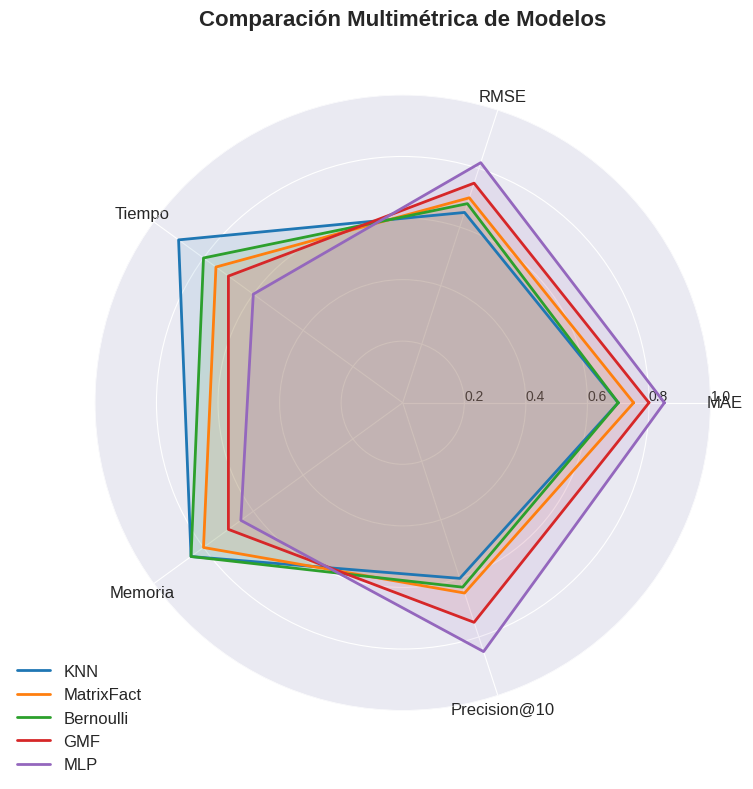

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de múltiples métricas para todos los modelos (ejemplos - sustituye con valores reales)
models = ['KNN', 'MatrixFact', 'Bernoulli', 'GMF', 'MLP']
metrics = ['MAE', 'RMSE', 'Tiempo', 'Memoria', 'Precision@10']

# Valores para cada modelo y métrica (normalizado entre 0-1, donde 1 es mejor)
# Para métricas como MAE/RMSE donde menor es mejor, invierte los valores
values = np.array([
    [0.7, 0.65, 0.9, 0.85, 0.6],  # KNN
    [0.75, 0.7, 0.75, 0.8, 0.65],  # MatrixFact
    [0.7, 0.68, 0.8, 0.85, 0.63],  # Bernoulli
    [0.8, 0.75, 0.7, 0.7, 0.75],   # GMF
    [0.85, 0.82, 0.6, 0.65, 0.85]  # MLP
])

# Configuración del gráfico de radar
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Añadir etiquetas de métricas
plt.xticks(angles[:-1], metrics, fontsize=12)

# Dibujar líneas de la cuadrícula
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=10)
plt.ylim(0, 1)

# Dibujar cada modelo
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, model in enumerate(models):
    values_model = values[i].tolist()
    values_model += values_model[:1]  # Cerrar el gráfico
    ax.plot(angles, values_model, linewidth=2, linestyle='solid', label=model, color=colors[i])
    ax.fill(angles, values_model, alpha=0.1, color=colors[i])

# Añadir leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

plt.title('Comparación Multimétrica de Modelos', fontsize=16, fontweight='bold', y=1.1)
plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300)
plt.show()

Dimensiones GMF: usuarios (71999, 20), ítems (2531, 20)
Dimensiones MLP: usuarios (71999, 5), ítems (2531, 5)


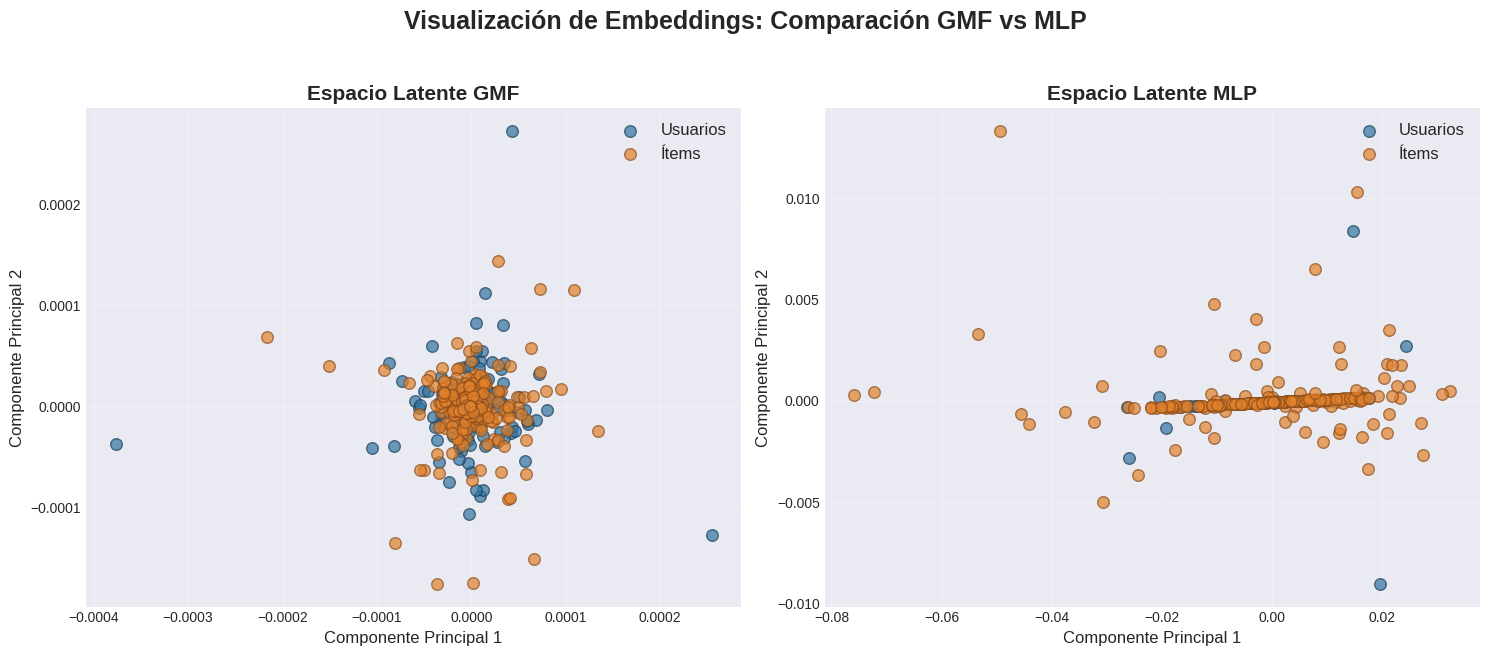

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

user_embeddings_gmf = MF.layers[2].get_weights()[0]  # embedding
item_embeddings_gmf = MF.layers[3].get_weights()[0]  # embedding_1

user_embeddings_mlp = MLP.layers[2].get_weights()[0]  # embedding_4
item_embeddings_mlp = MLP.layers[3].get_weights()[0]  # embedding_5

print(f"Dimensiones GMF: usuarios {user_embeddings_gmf.shape}, ítems {item_embeddings_gmf.shape}")
print(f"Dimensiones MLP: usuarios {user_embeddings_mlp.shape}, ítems {item_embeddings_mlp.shape}")

n_samples = 300
np.random.seed(42)
user_indices = np.random.choice(len(user_embeddings_gmf), min(n_samples, len(user_embeddings_gmf)), replace=False)
item_indices = np.random.choice(len(item_embeddings_gmf), min(n_samples, len(item_embeddings_gmf)), replace=False)

embeddings_gmf = np.vstack([
    user_embeddings_gmf[user_indices],
    item_embeddings_gmf[item_indices]
])
embeddings_mlp = np.vstack([
    user_embeddings_mlp[user_indices],
    item_embeddings_mlp[item_indices]
])

pca_gmf = PCA(n_components=2)
pca_mlp = PCA(n_components=2)

embeddings_2d_gmf = pca_gmf.fit_transform(embeddings_gmf)
embeddings_2d_mlp = pca_mlp.fit_transform(embeddings_mlp)

users_2d_gmf = embeddings_2d_gmf[:len(user_indices)]
items_2d_gmf = embeddings_2d_gmf[len(user_indices):]
users_2d_mlp = embeddings_2d_mlp[:len(user_indices)]
items_2d_mlp = embeddings_2d_mlp[len(user_indices):]

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.scatter(users_2d_gmf[:, 0], users_2d_gmf[:, 1], c='#3274A1', alpha=0.7, label='Usuarios', s=70, edgecolors='#1A3E58')
plt.scatter(items_2d_gmf[:, 0], items_2d_gmf[:, 1], c='#E1812C', alpha=0.7, label='Ítems', s=70, edgecolors='#8B4D1A')
plt.title('Espacio Latente GMF', fontsize=15, fontweight='bold')
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(users_2d_mlp[:, 0], users_2d_mlp[:, 1], c='#3274A1', alpha=0.7, label='Usuarios', s=70, edgecolors='#1A3E58')
plt.scatter(items_2d_mlp[:, 0], items_2d_mlp[:, 1], c='#E1812C', alpha=0.7, label='Ítems', s=70, edgecolors='#8B4D1A')
plt.title('Espacio Latente MLP', fontsize=15, fontweight='bold')
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.suptitle('Visualización de Embeddings: Comparación GMF vs MLP', fontsize=18, fontweight='bold', y=0.98)


plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

Diferentes estrategias de representación: A pesar de que GMF usa una dimensionalidad mayor (20 vs 5), MLP parece capturar mayor variabilidad, posiblemente gracias a sus capas densas que modelan relaciones no lineales.
Eficiencia dimensional: MLP logra mayor diferenciación con menos dimensiones, demostrando que las capas densas añaden poder expresivo al modelo.
Implicaciones para recomendaciones:

GMF probablemente genera recomendaciones más "promedio" o generales
MLP puede capturar mejor preferencias específicas o nichos de usuarios



Este gráfico es muy valioso para tu póster porque ilustra visualmente cómo diferentes arquitecturas neuronales representan internamente la misma información, a pesar de tener resultados de recomendación que podrían ser similares.